In [5]:
#importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import gmsh
import time
import pylab as pl
import gmsh
from IPython import display
from matplotlib.path import Path
from scipy.sparse import coo_array
from collections import Counter
%matplotlib inline
import scipy
import time
from multiprocessing import Manager,Pool
from worker import matrix_helper
import gc
import cProfile
import pstats

In [6]:
def read_mesh(filepath):
    '''
    Takes in an msh file and should return nodal coordinates and element connectivity in each physical group along with the boundary nodes 
    '''
    gmsh.initialize()
    gmsh.open(filepath)
    print(f"Reading {filepath}")
    print(f"Number of nodes in the mesh: {int(gmsh.option.getNumber("Mesh.NbNodes"))}")
    print(f"Number of triangles in the mesh: {int(gmsh.option.getNumber("Mesh.NbTriangles"))}\n")

    #Get all nodes
    dim = -1
    tag = -1
    nodeTags, nodecoords, _ = gmsh.model.mesh.getNodes(dim,tag)
    nodecoords = nodecoords.reshape(-1,3) #tags start from 1

    #Get all triangles
    eleType = 2
    tag = -1
    elements_t,ele_con = gmsh.model.mesh.getElementsByType(eleType,-1)
    ele_con = ele_con.reshape(-1,3)  #tags start from 1


    gmsh.finalize()
    return [nodecoords,ele_con] 

In [7]:
def Q(point,centre,ro):
    x = point[0,0] - centre[0,0]
    y = point[0,1] - centre[0,1]
    Qo = 5 ## amplitude in W/mm^2 
    return Qo*np.exp(-(x**2+y**2)/ro**2)  ## W/m^3

def rho_Ti(T, phase = 'alpha'):
    if phase == 'alpha':
        return -5.13e-5*(T**2)-0.01935*T+4451
    elif phase == 'beta':
        return -2.762e-6*(T**2)-0.1663*T+4468
    elif phase == 'liquid':
        return -0.565*T+5093
    else:
        return T

def cp_Ti(T,phase = 'alpha'):
    if phase == 'alpha':
        return 0.25*T+483
    elif phase == 'beta':
        return 0.14*T+530
    elif phase == 'liquid':
        return 930
    else:
        return T

def k_Ti(T,phase = 'alpha'):
    if phase == 'alpha':
        return 0.012*T+3.3
    elif phase == 'beta':
        return 0.016*T-3
    elif phase == 'liquid':
        return 0.0175*T-4.5
    else:
        return T

def props_chooser(T, T_rep, process = 'heating'):
    if (T_rep<1268 and process == 'heating') or (T_rep<=1073 and process == 'cooling'):
        return rho_Ti(T,phase = 'alpha'),cp_Ti(T,phase = 'alpha'),k_Ti(T,phase = 'alpha')
    elif (T_rep<1928 and process == 'heating') or (T_rep>1073 and process == 'cooling'):
        return rho_Ti(T,phase = 'beta'),cp_Ti(T,phase = 'beta'),k_Ti(T,phase = 'beta')
    elif (T_rep>=1928 and process == 'heating') or (T_rep>=1878 and process == 'cooling'):
        return rho_Ti(T,phase = 'liquid'),cp_Ti(T,phase = 'liquid'),k_Ti(T,phase = 'liquid')
    else:
        return -1
        
def flatten(xss):
    return [x for xs in xss for x in xs]   

In [25]:
class FEM:
    def __init__(self,nodecoords,elecon,centre):
        self.data_line = {"ips":{2:[-1/np.sqrt(3),1/np.sqrt(3)],3:[-np.sqrt(3/5),0,np.sqrt(3/5)]},\
        "weights":{2:[1,1],3:[5/9,8/9,5/9]}}
        self.data_tle = {"ips":{1:[[1/3,1/3]],3:[[1/6,1/6],[1/6,2/3],[2/3,1/6]]},\
       "weights":{1:[1/2],3:[1/6,1/6,1/6]}}
        self.nodecoords = nodecoords
        self.centre = centre
    
    def fit_ele(self,nodes,ele,theta_prev_time = None,theta_prev_pic = None,mode = "linear",verbose = False):
        '''
        Return mass and stiffness matrices alongside the forcing vector
        '''
        # profiler = cProfile.Profile()
        # profiler.enable()
        self.nodecoords = nodes
        self.elecon = ele
        
        gp = 3

        qo = 1e-3   # W/mm^2
        c = 658 #J/kg.K
        rho = 7.6e-6 #kg/mm^3
        kappa = 0.025 #W/mm.K
        ro = 2 #mm
        vo = -2 #mm/s
        
        #getting in the required data and doing the initialization
        nop = nodes.shape[0]
        ips = np.array(self.data_tle["ips"][gp])
        weights = np.array(self.data_tle["weights"][gp])

        K = np.zeros((nop,nop))
        G = np.zeros((nop,nop))
        K_row,K_col,K_data = [],[],[]
        G_row,G_col,G_data = [],[],[]
        # F = np.zeros((nop,1))
        # boundary_term = np.zeros((nop,1))

        ln = np.where(nodes[:,0] == 0)[0]
        rn = np.where(nodes[:,0] == np.max(nodes[:,0]))[0]
        bn = np.where(nodes[:,1] == 0)[0]
        tn = np.where(nodes[:,1] == np.max(nodes[:,1]))[0]

        items = [(nodes,elei,self.centre,theta_prev_time,theta_prev_pic,mode) for elei in ele]
        st = time.time()
        with Pool(processes = 4) as pool:
            results = pool.map(matrix_helper, items)
        print(f"Time for pooling to end {time.time()-st}")

        st = time.time()
        K_row, K_col, K_data, G_row, G_col, G_data, F_row,F_data, BT_row, BT_data,areas = list(zip(*results))
        mega = [K_row, K_col, K_data, G_row, G_col, G_data, F_row,F_data, BT_row, BT_data]
        K_row, K_col, K_data, G_row, G_col, G_data, F_row,F_data, BT_row, BT_data = [flatten(mini) for mini in mega]
        print(f"Time for accumulation to end {time.time()-st}")

        st = time.time()
        F= coo_array((F_data,(F_row,[0]*len(F_row))),shape = ((nop,1))).toarray()
        boundary_term = coo_array((BT_data,(BT_row,[0]*len(BT_row))),shape = ((nop,1))).toarray()
        print(f"Time for matrix formation to end {time.time()-st}")


        # for elei in ele:
        #     self.matrix_helper(elei,theta_prev_time = theta_prev_time,theta_prev_pic = theta_prev_pic,mode = mode)

        
        if verbose == True:
            print(f"Mesh size is {np.sqrt(np.mean(areas))}")
            print(f"Spot radius is {ro}")
        T_l = 273+20

        print(f"Time for loop to end {time.time()-st}")
        st = time.time()
        K_sparse = coo_array((K_data,(K_row,K_col)),shape=(nop,nop))
        G_sparse = coo_array((G_data,(G_row,G_col)),shape=(nop,nop))
        if verbose == True:
            print(f"Time for sparse conversion {time.time()-st}")

        st = time.time()
        K = K_sparse.toarray()
        G = G_sparse.toarray()
        if verbose == True:
            print(f"Time for sparse to dense conversion {time.time()-st}")
        
        non_ln = np.setdiff1d(np.arange(K.shape[0]),ln)
        rhs = F+boundary_term-T_l*np.sum((K[np.ix_(np.arange(K.shape[0]),ln)]\
                                          +G[np.ix_(np.arange(K.shape[0]),ln)]),axis = 1).reshape(-1,1)
        K_sub = K[np.ix_(non_ln,non_ln)]
        G_sub = G[np.ix_(non_ln,non_ln)]
        rhs_sub = rhs[np.ix_(non_ln,[0])]

        K_sparse = coo_array(K_sub)
        G_sparse = coo_array(G_sub)
        rhs_sparse = coo_array(rhs_sub)
        st = time.time()
        theta_sub = scipy.sparse.linalg.spsolve(K_sparse+G_sparse,rhs_sparse)
        print(f"Time for inversion {time.time()-st}")

        theta = np.zeros((K.shape[0],1))+T_l
        theta[non_ln,:] = theta_sub.reshape(-1,1)

        # profiler.disable()
        # stats = pstats.Stats(profiler)
        # stats.strip_dirs().sort_stats("time").print_stats(10)
        
        return [K,G,F,boundary_term,theta]


In [29]:
mesh_size_factor = 2

In [32]:
filename = f"rectangle_{mesh_size_factor}.msh"
# filename = f"rectangle_vary_0.5_1.msh"
nodecoords,ele_con = read_mesh(filename) #node tags start from 1
soln1 = FEM(nodecoords,ele_con,np.array([[50,25]]))
K,G,F,boundary,theta = soln1.fit_ele(nodecoords,ele_con,verbose = False)
gc.collect()

Reading rectangle_2.msh
Number of nodes in the mesh: 1542
Number of triangles in the mesh: 2932

Time for pooling to end 4.734369993209839
Time for accumulation to end 0.14156508445739746
Time for matrix formation to end 0.2482445240020752
Time for loop to end 0.2482445240020752
Time for inversion 0.03229236602783203


4

In [33]:
print(np.sum(boundary))

-0.25000000000000006


In [34]:
print(np.sum(K))

1.1796119636642288e-15


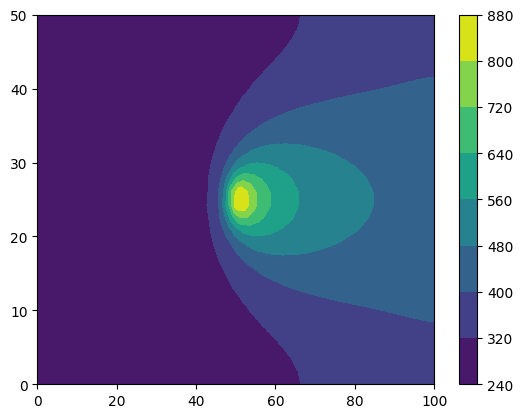

In [35]:
plt.tricontourf(nodecoords[:,0],nodecoords[:,1],theta.flatten())
plt.colorbar()
plt.show()

In [36]:
print(np.max(theta))

868.6236335143598


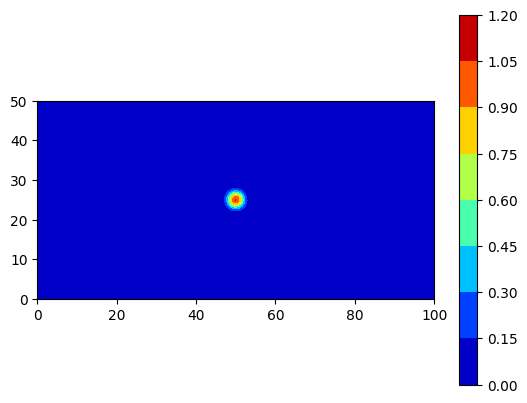

In [11]:
### Plotting the gaussian
plt.tricontourf(nodecoords[:,0],nodecoords[:,1], F.flatten(),cmap = 'jet')
plt.colorbar()
plt.gca().set_aspect('equal')
plt.show()

## Picard iteration for moving source heat conduction

In [12]:
def picard(nodecoords,ele_con,theta_init,source):
## the idea is you initialize a temperature profile and find corresponding multipliers for the non linear terms
    #non is number of nodes
    theta_old = theta_init

    e = 1e5
    tolerance = 1e-4
    iter = 0
    
    while(e>tolerance):
        iter +=1
        _,_,_,_,theta_new = FEM(nodecoords,ele_con,source).fit_ele(nodecoords,ele_con,theta_prev_time = theta_init,theta_prev_pic = theta_old,mode = "non_linear")
        e = np.linalg.norm(theta_new - theta_old)
        theta_old = theta_new
        print(f"Error at {iter} iteration is {e:.2E}")
        # print(theta_init)

    plt.tricontourf(nodecoords[:,0],nodecoords[:,1],theta_new.flatten())
    plt.title(f"Converged solution after {iter} iterations")
    plt.colorbar()
    plt.show()

    return theta_new
        
        

Time is 0 seconds
Time for pooling to end 7.277167558670044
Time for accumulation to end 0.09384703636169434
Time for matrix formation to end 0.031207561492919922
Time for loop to end 0.031207561492919922
Time for sparse conversion 0.15867090225219727
Time for sparse to dense conversion 0.10566353797912598
Time for inversion 0.40619707107543945
         9472 function calls (9215 primitive calls) in 12.229 seconds

   Ordered by: internal time
   List reduced from 521 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   115/36    6.058    0.053    9.604    0.267 {built-in method _winapi.WaitForMultipleObjects}
       17    2.034    0.120    2.153    0.127 {built-in method _overlapped.GetQueuedCompletionStatus}
        3    1.714    0.571    1.714    0.571 {method 'nonzero' of 'numpy.ndarray' objects}
       19    0.711    0.037    0.711    0.037 {built-in method _pickle.loads}
        5    0.383    0.077    9.812    1.962 {built-in me

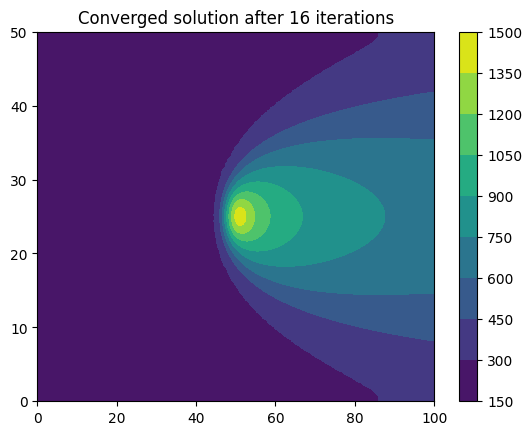

Time is 1 seconds
Time for pooling to end 6.552687168121338
Time for accumulation to end 0.07823777198791504
Time for matrix formation to end 0.03119206428527832
Time for loop to end 0.03119206428527832
Time for sparse conversion 0.15623784065246582
Time for sparse to dense conversion 0.09407782554626465
Time for inversion 0.04685831069946289
         9166 function calls (8970 primitive calls) in 10.170 seconds

   Ordered by: internal time
   List reduced from 511 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   107/42    5.578    0.052    9.674    0.230 {built-in method _winapi.WaitForMultipleObjects}
        3    1.246    0.415    1.246    0.415 {method 'nonzero' of 'numpy.ndarray' objects}
       11    1.176    0.107    9.931    0.903 windows_events.py:443(select)
       17    0.788    0.046    0.909    0.053 {built-in method _overlapped.GetQueuedCompletionStatus}
       19    0.639    0.034    0.639    0.034 {built-in method

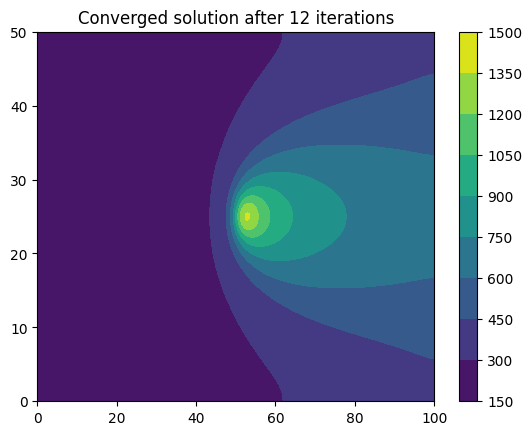

Time is 2 seconds
Time for pooling to end 5.695551872253418
Time for accumulation to end 0.09070658683776855
Time for matrix formation to end 0.0474238395690918
Time for loop to end 0.0474238395690918
Time for sparse conversion 0.1561417579650879
Time for sparse to dense conversion 0.07963180541992188
Time for inversion 0.04685473442077637
         9120 function calls (8930 primitive calls) in 8.868 seconds

   Ordered by: internal time
   List reduced from 511 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   103/36    4.704    0.046    5.825    0.162 {built-in method _winapi.WaitForMultipleObjects}
        3    1.528    0.509    1.528    0.509 {method 'nonzero' of 'numpy.ndarray' objects}
        6    1.089    0.182    2.683    0.447 {built-in method select.select}
       19    0.575    0.030    0.575    0.030 {built-in method _pickle.loads}
       17    0.172    0.010    0.275    0.016 {built-in method _overlapped.GetQueuedComp

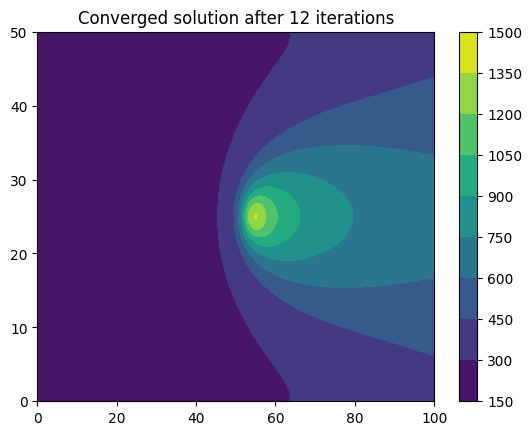

Time is 3 seconds
Time for pooling to end 5.534338712692261
Time for accumulation to end 0.09374046325683594
Time for matrix formation to end 0.03125786781311035
Time for loop to end 0.03125786781311035
Time for sparse conversion 0.1574561595916748
Time for sparse to dense conversion 0.07758736610412598
Time for inversion 0.06247878074645996
         8709 function calls (8531 primitive calls) in 8.756 seconds

   Ordered by: internal time
   List reduced from 511 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    95/26    4.704    0.050    0.087    0.003 {built-in method _winapi.WaitForMultipleObjects}
        3    1.587    0.529    1.587    0.529 {method 'nonzero' of 'numpy.ndarray' objects}
        6    1.040    0.173    2.696    0.449 {built-in method select.select}
       19    0.527    0.028    0.527    0.028 {built-in method _pickle.loads}
       17    0.130    0.008    0.224    0.013 {built-in method _overlapped.GetQueuedCo

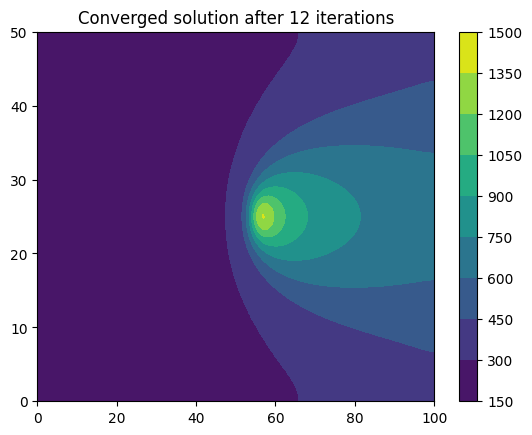

Time is 4 seconds
Time for pooling to end 5.629746913909912
Time for accumulation to end 0.07883787155151367
Time for matrix formation to end 0.0312039852142334
Time for loop to end 0.0312039852142334
Time for sparse conversion 0.15624594688415527
Time for sparse to dense conversion 0.09378433227539062
Time for inversion 0.047594547271728516
         9002 function calls (8812 primitive calls) in 8.852 seconds

   Ordered by: internal time
   List reduced from 511 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   102/36    4.831    0.047    6.868    0.191 {built-in method _winapi.WaitForMultipleObjects}
       11    1.122    0.102    8.839    0.804 windows_events.py:443(select)
        3    0.983    0.328    0.983    0.328 {method 'nonzero' of 'numpy.ndarray' objects}
       17    0.728    0.043    0.832    0.049 {built-in method _overlapped.GetQueuedCompletionStatus}
       19    0.511    0.027    0.511    0.027 {built-in method _

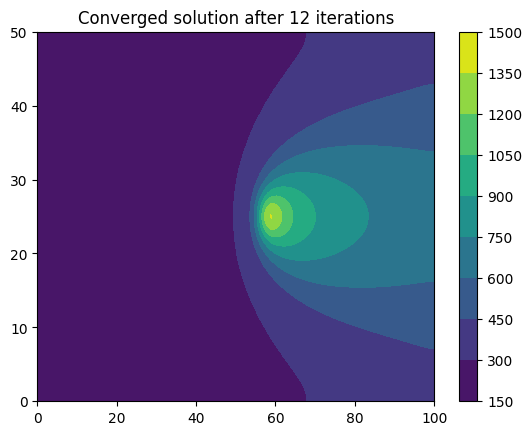

Time is 5 seconds
Time for pooling to end 6.049911260604858
Time for accumulation to end 0.07818841934204102
Time for matrix formation to end 0.03122854232788086
Time for loop to end 0.03122854232788086
Time for sparse conversion 0.17238473892211914
Time for sparse to dense conversion 0.08026885986328125
Time for inversion 0.046878814697265625
         9056 function calls (8865 primitive calls) in 9.227 seconds

   Ordered by: internal time
   List reduced from 511 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   103/28    4.627    0.045    1.284    0.046 {built-in method _winapi.WaitForMultipleObjects}
        3    1.559    0.520    1.559    0.520 {method 'nonzero' of 'numpy.ndarray' objects}
        6    1.083    0.180    2.689    0.448 {built-in method select.select}
       18    0.613    0.034    0.729    0.041 {built-in method _overlapped.GetQueuedCompletionStatus}
       19    0.514    0.027    0.514    0.027 {built-in meth

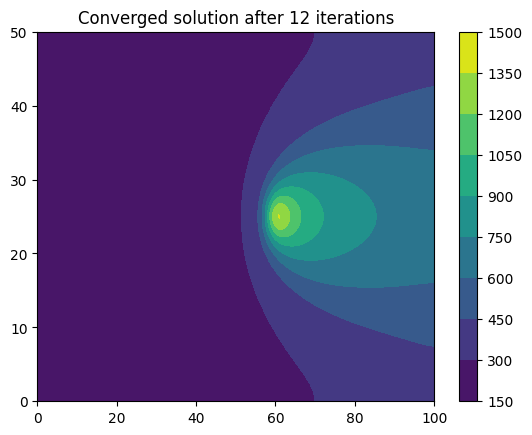

Time is 6 seconds
Time for pooling to end 8.30999207496643
Time for accumulation to end 0.12445068359375
Time for matrix formation to end 0.037506103515625
Time for loop to end 0.037506103515625
Time for sparse conversion 0.20348572731018066
Time for sparse to dense conversion 0.09419894218444824
Time for inversion 0.06797981262207031
         9236 function calls (9033 primitive calls) in 12.824 seconds

   Ordered by: internal time
   List reduced from 511 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   100/37    6.625    0.066    4.162    0.112 {built-in method _winapi.WaitForMultipleObjects}
        3    2.304    0.768    2.304    0.768 {method 'nonzero' of 'numpy.ndarray' objects}
       15    1.525    0.102    9.133    0.609 windows_events.py:443(select)
       19    0.680    0.036    0.680    0.036 {built-in method _pickle.loads}
       20    0.650    0.033    0.758    0.038 {built-in method _overlapped.GetQueuedCompletion

In [ ]:
T_l = 273+1000
t_final = 10
times = np.arange(0,t_final,1)
theta_init = np.zeros((nodecoords.shape[0],1))+T_l
theta_prev = theta_init
#Let's move the source
x_source = 50
for t in times:
    print(f"Time is {t} seconds")
    theta_final = picard(nodecoords,ele_con,theta_prev,source = np.array([[x_source+2*t,25]]))
    theta_prev = theta_final

In [ ]:
np.max(theta_final)

## Picard iteration validation

In [ ]:
def Q(point):
    x = point[0,0] #in mm
    return 15e-3*(x/100)*(1-x/100) ## W/mm^3

def k_T(T):
    # return np.ones_like(T)*110
    return (100+0.004*(T-50-273)**2)*1e-3  ##W/mmK

In [ ]:
class Picard_valid:
    def __init__(self):
        self.data_line = {"ips":{2:[-1/np.sqrt(3),1/np.sqrt(3)],3:[-np.sqrt(3/5),0,np.sqrt(3/5)]},\
        "weights":{2:[1,1],3:[5/9,8/9,5/9]}}
        self.data_tle = {"ips":{1:[[1/3,1/3]],3:[[1/6,1/6],[1/6,2/3],[2/3,1/6]]},\
       "weights":{1:[1/2],3:[1/6,1/6,1/6]}}
                        
    def fit_ele(self,nodes,ele,dt,theta_prev_time = None,theta_prev_pic = None,mode = "linear",scheme = "implicit"):
        '''
        Return mass and stiffness matrices alongside the forcing vector
        '''
        gp = 3

        qo = 0   # W/mm^2
        c = 465 #J/kg.K
        rho = 7e-6 #kg/mm^3
        
        #getting in the required data and doing the initialization
        nop = nodes.shape[0]
        ips = np.array(self.data_tle["ips"][gp])
        weights = np.array(self.data_tle["weights"][gp])

        K = np.zeros((nop,nop))
        M = np.zeros((nop,nop))
        F = np.zeros((nop,1))
        boundary_term = np.zeros((nop,1))

        ln = np.where(nodes[:,0] == 0)[0]
        rn = np.where(nodes[:,0] == np.max(nodes[:,0]))[0]
        bn = np.where(nodes[:,1] == 0)[0]
        tn = np.where(nodes[:,1] == np.max(nodes[:,1]))[0]

        for i,elei in enumerate(ele):
            econ = elei-1
            boundary = nodes[np.ix_(econ,[0,1])]
            dN = np.array([[-1,1,0],[-1,0,1]])
            Jac = np.matmul(dN,boundary)
            if np.linalg.det(Jac)<0:
                econ[0],econ[1] = econ[1],econ[0] #reordering for the direction to be counter clockwise
                boundary = nodes[np.ix_(econ,[0,1])] 
                Jac = np.matmul(dN,boundary)
            dN_dx = (np.linalg.inv(Jac)@dN)[0].reshape(1,-1) #1x3
            Jac_inv = np.linalg.inv(Jac)
            for j,ipj in enumerate(ips):
                N = np.array([[(1-ipj[0]-ipj[1]), ipj[0],ipj[1]]])
                a = (Jac_inv@dN).T@(Jac_inv@dN)*(np.linalg.det(Jac))*weights[j]
                b = N.T@dN_dx*(np.linalg.det(Jac))*weights[j]
                m = np.matmul(N.T,N)*np.linalg.det(Jac)*weights[j]
                if mode == "non_linear":
                    kappa = N@k_T(theta_prev_pic[np.ix_(econ,[0])])
                K[np.ix_(econ,econ)] += kappa*a
                M[np.ix_(econ,econ)] += rho*c*m
                # G[np.ix_(econ,econ)] += rho*c*vo*b
                X  =np.matmul(N,boundary)
                f = N*Q(X)*np.linalg.det(Jac)*weights[j]
                F[np.ix_(econ,[0])] +=f.T


        T_b = 273+100
        non_bn = np.setdiff1d(np.arange(K.shape[0]),bn)
        rhs = (F+boundary_term+M@theta_prev_time/dt)\
               -T_b*np.sum(K[np.ix_(np.arange(K.shape[0]),bn)]+M[np.ix_(np.arange(K.shape[0]),bn)]/dt,axis = 1).reshape(-1,1)
        K_sub = K[np.ix_(non_bn,non_bn)]
        M_sub = M[np.ix_(non_bn,non_bn)]
        rhs_sub = rhs[np.ix_(non_bn,[0])]
        # print(K_sub)
        # print(np.sum(M_sub))
        # print(K_sub+M_sub/dt)
        # print("inverter:",np.sum(np.linalg.inv(K_sub+M_sub/dt)))
        # print("multiplier:",np.sum(((F+boundary_term+M@(theta_prev_time-273)/dt)\
        #        -(T_b-273)*np.sum(K[np.ix_(np.arange(K.shape[0]),bn)]+M[np.ix_(np.arange(K.shape[0]),bn)]/dt,axis = 1).reshape(-1,1))[np.ix_(non_bn,[0])]))
        # return
        theta_sub = np.linalg.inv(K_sub+M_sub/dt)@(rhs_sub)

        theta = np.zeros((K.shape[0],1))+T_b
        theta[non_bn,:] = theta_sub.reshape(-1,1)
        
        return [M,K,F,boundary_term,theta]

In [ ]:
def picard(soln,nodecoords,ele_con,theta_init):
## the idea is you initialize a temperature profile and find corresponding multipliers for the non linear terms
    #non is number of nodes

    dt = 1
    times = np.arange(0,10,dt)
    theta_prev_time = theta_init
    
    for t in times:
        if t == round(t):
            print(np.min(theta_prev_time)-273,' at ',nodecoords[np.argmin(theta_prev_time)])
            print(np.max(theta_prev_time)-273,' at ',nodecoords[np.argmax(theta_prev_time)])
        e = 1e5
        tolerance = 1e-4
        iter = 0
        theta_prev_pic = theta_prev_time
        while(e>tolerance):
            iter +=1
            ## Implicit formulation 
            M,K,F,boundary_term,theta_new = soln.fit_ele(nodecoords,ele_con,dt,theta_prev_time = theta_prev_time,theta_prev_pic = theta_prev_pic,mode = "non_linear",scheme = "implicit")
            # print("M:",np.sum(M))
            # print("K:",np.sum(K))
            # print("F:",np.sum(F))
            # print("boundary_term:",np.sum(boundary_term))
            e = np.linalg.norm(theta_new - theta_prev_pic)
            theta_prev_pic = theta_new
            if t == round(t):
                print(f"Error at {iter} iteration at time {t} is {e:.2E}")
        # print(np.any(boundary_term))  confirmation that b.t isn't contributing
        theta_prev_time = theta_new
        
    plt.tricontourf(nodecoords[:,0],nodecoords[:,1],theta_new.flatten()-273, cmap = 'plasma')
    plt.title(f"Converged solution")
    plt.colorbar()
    plt.show()

    return theta_new
        

In [ ]:
mesh_size_factor = 3
filename = f"square_{mesh_size_factor}.msh"
nodecoords,ele_con = read_mesh(filename) #node tags start from 1

In [ ]:
soln3 = Picard_valid()
T_b = 273+50
theta_init = np.zeros((nodecoords.shape[0],1))+T_b
theta_final = picard(soln3,nodecoords,ele_con,theta_init)

In [ ]:
#at node a
theta_final[np.where((nodecoords[:,0] == 0) * (nodecoords[:,1] == 100)) [0][0]]-273

In [ ]:
#at node b
theta_final[np.where((nodecoords[:,0] == 100) * (nodecoords[:,1] == 100)) [0][0]]-273

In [ ]:
a = [(1,2),(3,4)]

In [ ]:
list(zip(*a))